In [1]:
# hello
import json, re, time, pickle, locale, os, socket, codecs, sys
from random import random, choice, randint, shuffle
from collections import OrderedDict

from IPython.core.display import display, HTML
from IPython.display import Image, display, display_png, display_svg, SVG, clear_output
import gensim
from jinja2 import Template
import pygraphviz as pgv
from numpy import int64
from ipywidgets import widgets
from gensim.models.doc2vec import LabeledSentence
import numpy as np
from sklearn.manifold import TSNE

locale.setlocale(locale.LC_ALL, 'de_DE.utf-8')
if not os.path.exists('tree_logs'):
    os.makedirs('tree_logs')

In [2]:
files = {
    "lyrik": {
        "V3": {
            'sentences' : '/home/marcel/drive/data/eco/NAIL_DATAFIELD_txt/parsed_v3/parsed_v3_valid.txt',
            "model" : '/mnt/drive1/data/eco/doc2vec_models/parsed_v3_valid.doc2vec'
        },
        "V4": {
            "sentences" : '/mnt/drive1/data/eco/NAIL_DATAFIELD_txt/parsed_v4/parsed_v4_valid.txt',
            "model": '/mnt/drive1/data/eco/NAIL_DATAFIELD_txt/parsed_v4/parsed_v4_valid_tagged.doc2vec'
        }
    },    
    "local":{
        "V3": {
            "sentences": '../../data/NAIL_DATAFIELD_txt/parsed_v3/parsed_v3_valid.txt',
            "model" : '../../models/NAIL_DATAFIELD_txt/parsed_v3/parsed_v3_valid.doc2vec'    
        },
        "V4": {
            "sentences": '../../data/NAIL_DATAFIELD_txt/parsed_v4/parsed_v4_valid.txt',
            "model" : '../../data/NAIL_DATAFIELD_txt/parsed_v4/parsed_v4_valid.doc2vec'    
        }        
    }
}

In [3]:
# na which version u wanna go with?
V = 3

host = socket.gethostname() 

if host == 'lyrik':
    print "U ARE ON LYRIK"

files_ = files['lyrik'] if host == 'lyrik' else  files['local']
files_ = files_['V3'] if V == 3 else files_["V4"]

model_file = files_['model']
sentences_file = files_['sentences']

if not os.path.isfile(model_file):
    print "MODEL FILE IS NOT THERE. GO AND FIND IT"
if not os.path.isfile(sentences_file):
    print "TEXTFILE FILE IS NOT THERE"    

In [4]:
# progress bar

def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [5]:
# 2 Build sentence list (each sentence needs at least 1 tag)
sentences = []

f = codecs.open(sentences_file, 'r', 'UTF-8')
sentence_count = num_lines = sum(1 for line in open(sentences_file))
index = 0
for line in log_progress(f, size=sentence_count):
    if V == 3:
        ls = LabeledSentence(words=line.split(), tags=['SENT_%s' % index])
    elif V == 4:
        words = line.split(';')[0].split()
        #words = ''.join(line[1].split(';')[:-1]).split() 
        pdf = line.split(';')[1][:-5]
        #pdf = line[1].split(';')[:-1][:-5] # getting rid of the .pdf fileending
        tag = str(index) + '__' + pdf
        ls = LabeledSentence(words= words, tags=[tag])
        
    sentences.append(ls)
    index += 1
print len(sentences),'sentences'

4266193 sentences


In [6]:
# 3 TRAINING OR LOADING the doc2vec model and save it
# ALTERNATIVE: LOAD THE MODEL IN THE NEXT CELL

# tutorial https://rare-technologies.com/doc2vec-tutorial/
# proposes shuffling or learning reate adjustment. we gonna do both
# in total 20 epochs
# took ca. 6.30 hours

# FOR SAFETY REASON, BUILD ONLY WHEN FLAG IS SET

train_model = False

if train_model:
    model = gensim.models.Doc2Vec(alpha=0.025, min_alpha=0.025)  # use fixed learning rate
    print('building vocab') 
    model.build_vocab(sentences)

    base_alpha = model.alpha
    base_min_alpha = model.min_alpha

    for mepoch in range(2):
        model.alpha = base_alpha 
        model.min_alpha = base_min_alpha
        for epoch in range(10):
            print('epoch',mepoch * 10 + epoch)
            model.train(sentences)
            model.alpha -= 0.002  # decrease the learning rate
            model.min_alpha = model.alpha  # fix the learning rate, no decay
        shuffle(sentences)

    # saving the model    
    model.save(model_file)
    print 'model trained and saved'
else:
    model = gensim.models.Doc2Vec.load(model_file)
    print 'model loaded.',len(model.docvecs), 'vectors'
    if len(sentences) != len(model.docvecs):
        print 'something is fishy, unequal length: ',len(sentences),'sentences and',len(model.docvecs), 'vectors'

model loaded. 4266193 vectors


In [7]:
# 4 Tiny helper functions

def print_word_list(wl):
    str =  ' '.join(wl)
    pattern = re.compile('\s\W\s')
    shift = 0
    for ma in pattern.finditer(str):
        str = str[:ma.start(0)-shift]+ma.group(0)[1:]+ str[ma.end(0)-shift:]
        shift +=1
    if str[-2] == ' ':
        str = str[:-2] + str[-1:]
    return str

def get_print(sentence_or_similar):
    if type(sentence_or_similar) is gensim.models.doc2vec.LabeledSentence:
        word_list = sentence_or_similar.words
    elif type(sentence_or_similar) is int64 or type(sentence_or_similar) is int: # just an index
        word_list = sentences[sentence_or_similar].words
    else: # TaggedDocument class
        word_list = sentences[int(sentence_or_similar[0])][0]
    return print_word_list(word_list)
    
def get_index_tag(sentence):
    return sentence.tags[0]

def get_index(sentence_or_similar):
    if type(sentence_or_similar) is gensim.models.doc2vec.LabeledSentence:
        if V == 3:
            return int64(get_index_tag(sentence_or_similar)[5:])
        elif V == 4:
            return int64(get_index_tag(sentence_or_similar).split('__')[0])
    else:
        if V == 3:
            return int64(sentence_or_similar[0][5:])
        elif V == 4:
            return int64(sentence_or_similar[0].split('__')[0])
    
def equal_word_lists(index1, index2):
    wl1 = sentences[index1].words
    wl2 = sentences[index2].words
    if len(wl1) != len(wl2):
        return False
    else:
        for i in range(len(wl1)):
            if wl1[i] != wl2[i]:
                return False
    return True

def get_lab_sent_by_similar(similar):
    #print get_index(similar)
    return sentences[get_index(similar)]

def get_similarity_by_index(index1, index2):
    return model.docvecs.similarity(index1,index2)

def linebreak(sentence, afterChar):
    wordlist = sentence.split(' ')
    line_length = 0 
    result = ''
    for word in wordlist:
        line_length += len(word)
        result += word+' '
        if line_length > afterChar:
            result += '\n'
            line_length = 0
    return result

In [8]:
%%html
<style>
    .similar{
        color: black;
    }
    .random{
        color: red;
    }
    .parent{
        color: blue
    }
    .next{
        color: green
    }
    .noIndex {
        list-style-type: none;
    }
</style>

## Tree convesation

Works with 2 main classes and some helper functions

### 2 libraries: 
- _jinja2_ to create HTML templates. makes creating html simpler
- _pygraphviz_ for graph visualisation

### classes:

class **ConversationTree**
This class is used as singleton, holds the whole thing together and works as the interface to the user.
It gives each inserted node an id, so that the user can directyl jump to specific node. 
It keps track of the actual selected node and draws the graph (saving it to disc) 


class **ConversationNode**
Each Node in the tree keps track of its relevant information. Sentence, children, actual stying in the graph

### Flow:

Conversation tree is initiated with a sentence (LabeledSentence), which uses the _add_node_ method to create a root node. Then it loops through _display_tree_ to show the graph and _select_option_ until the end of time (or the user says its enough).

__display__

Since all nodes take care of their style, whenever the user interacts this method just saves a new image and shows it in the notebook.

__select_option__

first calls __display_options__, which uses _jinja2_ to create the html output for the actual node and it's options. (sidenote: since jinja template cannot contain emojis we are passing the 'end' and 'story_end' selectors as parameters)



In [9]:
class ConversationTree:
    
    def __init__(self, root_sentence):
        # pygraphviz Graph
        self.G = pgv.AGraph(strict=True, directed=True)
        # General styling
        self.G.node_attr['shape']='box'
        #
        self.next_node_id = 0
        self.actual_node = None
        self.inserted_sentence_indices = []
        self.root = self.add_node(root_sentence)
        self.actual_node = self.root
        self.log_index = 0 # comes from outside
         
    def add_node(self, sentence, edge_label = [], goto = True):
        node = ConversationNode(self, sentence, self.actual_node, edge_label)
        self.inserted_sentence_indices.append(node.sentence_index)
        if goto:
            self.change_actual(node)
        return node
    
    def change_actual(self, new_node):
        if self.actual_node: # None when adding the root
            self.actual_node.unstyle()
        self.actual_node = new_node
        self.actual_node.style_actual()        
    
    def next_id(self):
        """
            return next id and increment internal counter
        """
        id_ = self.next_node_id 
        self.next_node_id += 1
        return id_        
    
    def display(self, layout= 'dot', fformat = 'png'):
        if fformat not in ['png','svg']:
            print 'format is not real',fformat
            return
        name = 'tree_logs/tree_'+str(self.log_index) + '.'+fformat
#         self.create_sub_graph()
        tree.G.draw(name, prog = layout)
#         self.G.draw(name, prog = layout)
        if fformat == 'svg':
            display(SVG(name))
        else:
            display(Image(name))   

    def up(self, steps = 1):
        for step in range(steps):
            if self.actual_node.parent_edge:
                self.change_actual(self.actual_node.parent)
                        
    def remove_node(self, node):
        node_to_remove = node
        self.up()
        self.actual_node.remove_child(node_to_remove)
        self.inserted_sentence_indices.remove(node_to_remove.sentence_index)
                          
    def dump_stories(self):
        story_nodes = self.root.find_stories()
        story_file_name = 'tree_logs/story_'+str(self.log_index) + '.txt'
        with codecs.open(story_file_name, 'w', 'UTF-8') as out:
            for index, node in enumerate(story_nodes):
                story = node.get_story()
                out.write('Story '+ str(index) + ', id '+ str(node.id_) +'\n')
                for sen in story:
                    out.write(sen+'\n')
            
        
    ### DOV2VEC stuff

    def get_similars(self):
        return self.actual_node.get_similars()
    
    def get_all_options(self):
        return self.actual_node.get_all_options()
    
    ###
    
    def display_options(self):
        all_options = self.actual_node.get_all_options()
        template = Template('''
        <h2>{{sentence}}</h2>
        <ol>
        {% for item in options %}
        <li class={{item.type}} id="ind{{loop.index}}">{{item.hint}} {{item.sentence}} / {{item.similarity}}</li>
        {% endfor %}
        {% if delete %}
        <li class='noIndex'> d: {{delete}} - remove and up(only cool for leafes so far) </li>
        {% endif %}
        <li class='noIndex'> s: {{story_end}} - swap story-end </li>
        <li class='noIndex'> q: {{end}} - end </li>
        </ol>
        ''')
        sentence = self.actual_node.label# self.actual_node.pretty_print() + 
        params = {
            'sentence' : sentence,
            'options' : all_options, 
            'end' : u'💣', 
            'story_end': u'📖'
        }
        if self.actual_node.parent:
            params['delete'] = u'✂️'
        display(HTML(template.render(params)))
        return all_options

    def select_option(self):
        all_options = self.display_options()
        time.sleep(0.2)
        selection = raw_input("what's next?") 
        if selection == 'q':
            return False
        elif selection == 'd':
            self.remove_node(self.actual_node)
        elif selection == 's':
            self.actual_node.swap_story_end()
            return True
        elif selection.startswith('ID'):
            try:
                new_id = int(selection[2:])
                print('selecting id ' + str(new_id))
                new_node = self.find_node(new_id)
                if new_node:
                    self.change_actual(new_node)
                return True
            except ValueError:
                return True
        else:
            try:
                selected_index = int(selection)
            except ValueError:
                return True
            if selected_index >= 1 and selected_index <= len(all_options):
                selected_option = all_options[selected_index - 1]
    #             print selected_option['index'], self.actual_node.children
                if selected_option['type'] == 'parent':
                    self.up()
                elif selected_option['index'] in self.actual_node.children:
                    self.change_actual(self.actual_node.children[selected_option['index']])
                else:
                    selected_sentence = sentences[int(selected_option['index'])]
                    edge_label = [selected_option['similarity'], selected_option['type']]
                    self.add_node(selected_sentence, edge_label)
        return True

    def log(self):
        with open('tree_logs/tree_'+str(self.log_index)+'.json','w') as out:
            out.write(json.dumps(self.to_json()))
                
    def to_json(self):
        dict_ = self.root.to_json()
        dict_['next_node_id'] = self.next_node_id 
        dict_['actual_node_id'] = self.actual_node.id_
        return dict_
    
    def from_json(self, dict_):
        self.root.from_json(dict_)
        self.next_node_id = dict_['next_node_id']
        
    def find_node(self, id):
        return self.root.find_node(id)
            
class ConversationNode():
    
    def __init__(self, conv_tree, sentence, parent, edge_label = []):
        self.conv_tree = conv_tree
        self.graph = conv_tree.G  
        self.id_ = conv_tree.next_id()
        self.sentence = sentence
        self.sentence_index = get_index(self.sentence)
        self.label = self.build_label()
        self.child_edges = OrderedDict()
        self.children = OrderedDict()
        self.g_node = self.update_graph()
        self.style({'style':'filled', 'fillcolor':'azure3', 'label': self.label})
        self.options = None
        self.is_leaf = True
        self.story_end = True
        if parent:
            self.parent = parent
            self.parent_edge = parent.add_child(self, edge_label)
            self.level = parent.level + 1
        else:
            self.parent = None
            self.parent_edge = None
            self.level = 0
    
    def build_label(self):
        if V == 3:
            return str(self.id_) +', '+ str(self.sentence_index) +   ' | ' + linebreak(self.pretty_print(),30)
        if V == 4:
            pdf_label = sentences[self.sentence_index].tags[0].split('__')[1]
            return str(self.id_) +', '+ str(self.sentence_index) + ', ' + linebreak(self.pretty_print(),30) + ', ' + linebreak(pdf_label, 30)
        
    
    def update_graph(self):
        self.graph.add_node(self.id_)
        g_node = self.graph.get_node(self.id_)
        return g_node
    
    def add_child(self, node, edge_label = []):
        self.children[node.sentence_index]  = node
        child_edge = ConversationEdge(self, node,edge_label)   
        self.child_edges[node.sentence_index] = child_edge
        if self.is_leaf:
            self.set_leaf(False)
            self.set_story_end(False)
        return child_edge

    def remove_child(self, node):
        del self.children[node.sentence_index]
        del self.child_edges[node.sentence_index]
        if len(self.children) == 0:
            self.set_leaf(True)
            self.set_story_end(True)
        self.graph.delete_node(node.id_)
        
    def remove_all_children(self):
        for child in self.children.values():
            child.remove_all_children()
            self.remove_child(child)
            
    def style(self, style_dict):
        for k,v in style_dict.iteritems():
            self.g_node.attr[k] = v
    
    def style_actual(self):
        self.style({'color': "orange"}) 
        
    def unstyle(self):
        self.style({'color': "black"})
        
    def pretty_print(self):
        return get_print(self.sentence)
    
    def set_leaf(self, leaf):
        self.is_leaf = leaf
            
    def set_story_end(self, story_end):
        self.story_end = story_end
        self.style({'fillcolor':'azure3' if self.story_end else 'none'})
        
    def swap_story_end(self):
        self.set_story_end(not self.story_end)
        
    # doc2vec stuff
    
    def get_similars(self):
        similars =  model.docvecs.most_similar(get_index_tag(self.sentence),topn = num_similars)
        return [self.optionFormat(simi) for simi in similars]
    
    def get_randoms(self):
        randoms = []
        for index in range(num_random):
            rnd_sen = sentences[randint(0,len(sentences))]
            randoms.append(rnd_sen)     
        return [self.optionFormat(ran) for ran in randoms]
    
    def get_all_options(self):
        if not self.options:
            all_options = []
            self.similars = self.get_similars()
            self.randoms = self.get_randoms()
            all_options.extend(self.similars)
            if self.parent:
                all_options.append(self.optionFormat(self.parent, 'parent'))
            if self.sentence_index < len(sentences) - 2:
                all_options.append(self.optionFormat(sentences[self.sentence_index + 1],'next'))
            all_options.extend(self.randoms)
            self.options = all_options
        for option in self.options:
            if option['type'] == 'parent':
                option['hint'] = u'👴🏼'
            elif option['type'] == 'next':
                option['hint'] = u'➡️'
            else:
                option['hint'] = u''
            if option['type'] != "parent" and option['index'] in self.conv_tree.inserted_sentence_indices:
                option['hint'] += u'☝️'
            if option['index'] in self.children:
                option['hint'] += u'👶'
        return self.options

    def optionFormat(self, something, info = ''):
        d = {'hint' : ''}
        if type(something) is gensim.models.doc2vec.LabeledSentence:
            d['index'] = get_index(something) 
            d['similarity'] = ("%.3f" % get_similarity_by_index(self.sentence_index, d['index'])) 
            d['sentence'] = get_print(something)
            d['type'] = 'random'
            if info == 'next':
                d['type'] = 'next'
        # similars e.g. ('SENT_78', 0.790978193283081)
        elif isinstance(something, tuple):
            d['index'] = get_index(something)
            d['similarity'] = ("%.3f" % something[1])
            d['sentence'] = get_print(sentences[d['index']])
            d['type'] = 'similar'
        elif isinstance(something, ConversationNode):
            d['index'] = something.sentence_index
            d['similarity'] =("%.3f" % get_similarity_by_index(self.sentence_index, something.sentence_index))
            d['sentence'] = get_print(something.sentence)
            d['type'] = 'parent'
        return d
    
    def to_json(self):
        dict_ =  OrderedDict(
            [('id' , self.id_),
            ('sentence', self.sentence),
            ('sentence_index', self.sentence_index),
            ('story_end', self.story_end),
            ('children', zip(
                [edge.to_json() for edge in self.child_edges.values()],
                [child.to_json() for child in self.children.values()]))]
        )
        if self.conv_tree.actual_node is self:
            dict_['actual_node'] = '<<<<<<<<<<<<<<<<<<<'
        return dict_

    def from_json(self, dict_):
        self.id_ = dict_['id']
        self.sentence = LabeledSentence(words = dict_['sentence'][0], tags = dict_['sentence'][1])
        self.sentence_index = dict_['sentence_index']
        self.label = self.build_label()
        self.child_edges = OrderedDict()
        self.children = OrderedDict()
        if 'actual_node' in dict_:
            self.conv_tree.change_actual(self)
        self.g_node = self.update_graph()
        for edge_child in dict_['children']:
            sentence = LabeledSentence(words = edge_child[1]['sentence'][0], tags = edge_child[1]['sentence'][1])  
            child = ConversationNode(self.conv_tree, sentence, self,edge_child[0])
            child.from_json(edge_child[1])
        self.set_story_end(dict_['story_end'])
        self.conv_tree.inserted_sentence_indices.append(self.sentence_index)

    def find_stories(self):
        result = []
        if self.story_end:
            result.append(self)
        for child in self.children.values():
            result.extend(child.find_stories())
        return result

    def get_story(self):
        sentences = []
        node = self
        while node.parent:
            sentences.append(get_print(node.sentence))
            node = node.parent
        sentences.append(get_print(node.sentence))
        sentences.reverse()
        return sentences
    
    def find_node(self, id):
        if self.id_ == id:
            return self
        for child in self.children.values():
            children_result = child.find_node(id)
            if children_result:
                return children_result
        return None
    
class ConversationEdge(object):
        
    def __init__(self,from_node, to_node , label = []):
        self.id_ = (from_node.id_, to_node.id_)
        self.from_node = from_node
        self.to_node = to_node
        self.g_edge = self.update_graph()
        self.style({'label':' '+label[0]})
        self.type= 'similar'
        self.similarity = label[0]
        if label[1] == 'next':
            self.style({'color':'green'})
            self.type= 'next'
        elif label[1] == 'random':
            self.style({'color':'red'})
            self.type= 'random'
      
    
    def update_graph(self):
        self.from_node.graph.add_edge(self.id_)
        g_edge = self.from_node.graph.get_edge(*self.id_)     
        return g_edge
    
    def style(self, style_dict):
        for k,v in style_dict.iteritems():
            self.g_edge.attr[k] = v
            
    def to_json(self):
        return [self.similarity, self.type]

In [10]:
HTML("<script> var points=2</script>")
# print 2

sen_x = 0
n_sim = 100
similars = model.docvecs.most_similar(sen_x,topn = n_sim)
s_vecs = [] # doc vecs
s_sen = [] # sentences
s_vecs.append(model.docvecs[sen_x])
s_sen.append(get_print(sen_x))
# get the doc vecs of all similars and the sentences into the list
for vecs in similars:
    s_vecs.append(model.docvecs[int(vecs[0][5:])])
    s_sen.append(get_print(int(vecs[0][5:])))

    
import numpy as np
from sklearn.manifold import TSNE

# tsne that stuff (and transform it into a float array [didnt get it in a np one-liner])  
tsne_model = TSNE(n_components=2, random_state=0)
tsne_res = tsne_model.fit_transform(s_vecs)
tsnes_res_f = [[ts[0].item(),ts[1].item()] for ts in tsne_res ]

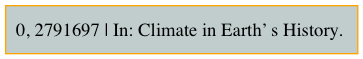

what's next?q


In [11]:
num_similars = 15
num_random = 15

load_from_log = False

number_logs = max(0,len(filter(lambda file_ : file_.endswith('.json'),
                          os.listdir("tree_logs"))) - 1)
tree = ConversationTree(choice(sentences))

if load_from_log:
    log_file = 'tree_logs/tree_'+str(number_logs)+'.json'
    with open(log_file,'r') as in_file:   
        tree.from_json(json.loads(in_file.read()))
    tree.log_index = number_logs
else:
    tree.log_index = 0 if number_logs == 0 else number_logs + 1

while True:
    clear_output()
    tree.display()
    tree.log()
    if not tree.select_option():
        tree.dump_stories()
        break

In [ ]:
tj = tree.to_json()
# print json.dumps(tj, indent = 2)
tree2 = ConversationTree(sentences[10])
tree2.from_json(tj)
tree.display()

In [21]:
# PYTHON > JS: THIS IS THE WAY TO GO
from IPython.display import Javascript
Javascript('window.vizObj={};'.format({"a":1}))
print 2

2
